<a href="https://colab.research.google.com/github/sedagulerr/NLP-ile-Tarot-Karti-Okuma/blob/main/TAROT_KARTI_OKUMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DoÄŸal dil iÅŸleme (NLP) modeli kullanÄ±larak kullanÄ±cÄ± girdilerine gÃ¶re tarot kartlarÄ± Ã¶neriliyor ve kartlarÄ±n anlamlarÄ± kullanÄ±cÄ±ya sunuluyor.

# NLP Modeli KullanÄ±mÄ±: Kodu yazarken SentenceTransformer modeli kullanÄ±lÄ±yor. Bu model, metin tabanlÄ± benzerlik hesaplamalarÄ± iÃ§in kullanÄ±lÄ±yor.

# KullanÄ±cÄ± Girdilerinin Ä°ÅŸlenmesi: KullanÄ±cÄ±nÄ±n girdiÄŸi metin analiz edilerek niyet belirleniyor ve uygun tarot kartÄ± seÃ§iliyor.

# GÃ¶rsellerin GÃ¶sterimi: KartlarÄ±n gÃ¶rselleri yÃ¼klenip gÃ¶steriliyor.

# Konsol Renkleri: Konsolda renkli ve stilize edilmiÅŸ Ã§Ä±ktÄ±lar oluÅŸturmak iÃ§in ANSI kaÃ§Ä±ÅŸ dizileri kullanÄ±lÄ±yor.

# Soru-Cevap ve Tavsiye MekanizmasÄ±: KullanÄ±cÄ± girdilerine gÃ¶re Ã¶nerilerde bulunan ve kullanÄ±cÄ±ya ikinci bir kart Ã¶nerisi sunan bir yapÄ±Â oluÅŸturuluyor.

In [2]:
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import json
import seaborn
import pandas as pd
import os
import cv2
import spacy
import ipywidgets as widgets
from IPython.display import display, clear_output
from pandas import json_normalize
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import SentenceTransformer
from scipy.ndimage import rotate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

In [3]:
# JSON dosyasÄ±ndan tarot kartlarÄ±nÄ± okuma
data_dir = '/content/'  # GÃ¶rsellerin ve JSON'un olduÄŸu dizin
df = pd.read_json(data_dir + 'tarot-images.json', orient='records')
df_cards = pd.json_normalize(df['cards'])
df_cards

name number        arcana       suit      img  \
0              The Fool      0  Major Arcana      Trump  m00.jpg   
1          The Magician      1  Major Arcana      Trump  m01.jpg   
2    The High Priestess      2  Major Arcana      Trump  m02.jpg   
3           The Empress      3  Major Arcana      Trump  m03.jpg   
4           The Emperor      4  Major Arcana      Trump  m04.jpg   
..                  ...    ...           ...        ...      ...   
73     Ten of Pentacles     10  Minor Arcana  Pentacles  p10.jpg   
74    Page of Pentacles     11  Minor Arcana  Pentacles  p11.jpg   
75  Knight of Pentacles     12  Minor Arcana  Pentacles  p12.jpg   
76   Queen of Pentacles     13  Minor Arcana  Pentacles  p13.jpg   
77    King of Pentacles     14  Minor Arcana  Pentacles  p14.jpg   

                                      fortune_telling  \
0   [Watch for new projects and new beginnings, Pr...   
1   [A powerful man may play a role in your day, Y...   
2   [A mysterious woman arrives, A sexual secret m...   
3   [Pregnancy is in the cards, An opportunity to ...   
4   [A father figure arrives, A new employer or au...   
..                                                ...   
73  [Big money is in the near future, Expect a pow...   
74  [This card represents a young man or woman wit...   
75  [A stingy person may chide you for spending mo...   
76  [This card represents a woman with an expansiv...   
77  [This card represents an older man with a fina...   

                                             keywords              Archetype  \
0           [freedom, faith, inexperience, innocence]      The Divine Madman   
1                 [capability, empowerment, activity]       The Ego/The Self   
2         [intuition, reflection, purity, initiation]  The Virgin/The Maiden   
3      [fertility, productivity, ripeness, nurturing]             The Mother   
4       [authority, regulation, direction, structure]             The Father   
..                                                ...                    ...   
73            [wealth, abundance, acquisition, greed]                    NaN   
74  [practicality, prosperity, learning, growth, a...                    NaN   
75               [caution, focus, realism, invention]                    NaN   
76  [luxury, comfort, resourcefulness, generosity,...                    NaN   
77  [stability, dependability, confidence, interve...                    NaN   

                                      Hebrew Alphabet  \
0                                          Aleph/Ox/1   
1                                        Beth/House/2   
2                                       Gimel/Camel/3   
3                                       Daleth/Door/4   
4   He[as]/Window/5, or in some decks, Tzaddi/Fish...   
..                                                ...   
73                                                NaN   
74                                                NaN   
75                                                NaN   
76                                                NaN   
77                                                NaN   

                                        Numerology        Elemental  \
0                0 (off the scale; pure potential)              Air   
1                        1 (origins, unity, seeds)  The Sun/Mercury   
2                    2 (division, debate, duality)         The Moon   
3             3 (expression, productivity, output)            Venus   
4             4 (stability, equality, persistence)       Mars/Aries   
..                                             ...              ...   
73  10 (The End: finality, completion, exhaustion)              NaN   
74                                             NaN  Earth of Earth.   
75                                             NaN    Air of Earth.   
76                                             NaN  Water of Earth.   
77                                             NaN   Fire of Earth.   

                  

In [4]:
# Konsol renkleri
class ConsoleColors:
    RESET = "\033[0m"
    BOLD = "\033[1m"
    CYAN = "\033[96m"
    RED = "\033[91m"
    YELLOW = "\033[93m"
    GREEN = "\033[92m"
    BLUE = "\033[94m"
    ORANGE = "\033[38;5;214m"

In [5]:
# BugÃ¼nÃ¼n nasÄ±l geÃ§ecek gÃ¶rmek ister misin?

BugÃ¼nÃ¼n nasÄ±l geÃ§ecek gÃ¶rmek ister misin? (evet/hayÄ±r): evet

Sizin iÃ§in seÃ§ilen kart: Six of Cups
AnlamÄ± (Light): ['Donating your time and talents to others', 'Taking satisfaction in knowing how your efforts will aid others', 'Creating a "win-win" scenario', 'Giving even when you know repayment is not possible', 'Being motivated to do a good deed']
AnlamÄ± (Shadow): ['Linking your sense of self-worth to the appraisals of others', 'Striving to appear more needy than you really are', 'Taking undeserved or unmerited charity', 'Bragging about your charitable efforts', 'Profiteering in times of distress', 'Refusing to share a burden']
KartÄ±n genel yorumu: Olumsuz âš¡


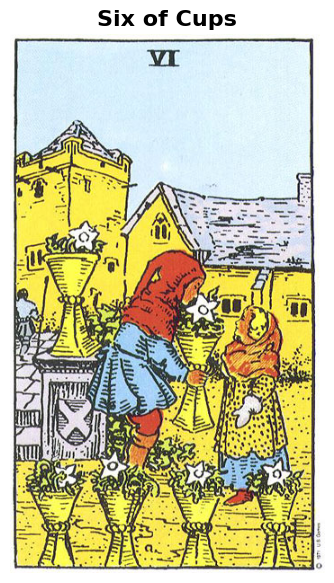

In [7]:
# JSON dosyasÄ±ndan tarot kartlarÄ±nÄ± okuma
df_cards = pd.json_normalize(df['cards'])

# KullanÄ±cÄ±ya sorma
response = input("BugÃ¼nÃ¼n nasÄ±l geÃ§ecek gÃ¶rmek ister misin? (evet/hayÄ±r): ").strip().lower()

if response in ["evet", "yes"]:
    # Rastgele bir kart seÃ§me
    random_card_idx = random.randint(0, len(df_cards) - 1)
    random_card = df_cards.iloc[random_card_idx]

    # Light ve Shadow anlamlarÄ±nÄ± karÅŸÄ±laÅŸtÄ±rma
    light_meanings = random_card['meanings.light']
    shadow_meanings = random_card['meanings.shadow']
    light_count = len(light_meanings)
    shadow_count = len(shadow_meanings)

    # Light ve Shadow'a gÃ¶re mesaj belirleme
    if light_count > shadow_count:
        dominance_message = f"{ConsoleColors.GREEN}KartÄ±n genel yorumu: Olumlu ðŸŒŸ{ConsoleColors.RESET}"
    elif shadow_count > light_count:
        dominance_message = f"{ConsoleColors.RED}KartÄ±n genel yorumu: Olumsuz âš¡{ConsoleColors.RESET}"
    else:
        dominance_message = f"{ConsoleColors.BLUE}KartÄ±n genel yorumu: Dengeli âš–{ConsoleColors.RESET}"

    # Kart bilgilerini yazdÄ±rma
    print(f"\nSizin iÃ§in seÃ§ilen kart: {random_card['name']}")
    print(f"AnlamÄ± (Light): {light_meanings}")
    print(f"AnlamÄ± (Shadow): {shadow_meanings}")
    print(dominance_message)

    # Kart gÃ¶rselini gÃ¶sterme
    image_path = os.path.join(data_dir, random_card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(random_card['name'], fontsize=16, fontweight='bold')
        plt.show()
    else:
        print(f"{ConsoleColors.RED}GÃ¶rsel bulunamadÄ±: {image_path}{ConsoleColors.RESET}")
else:
    print(f"{ConsoleColors.BLUE}Tamam, bir dahaki sefere gÃ¶rÃ¼ÅŸÃ¼rÃ¼z!{ConsoleColors.RESET}")

In [8]:
# Ne hisettigini yazinca bir kart onerme (ing olan)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n: How will my career progress?

Sizin iÃ§in seÃ§ilen kart: Seven of Pentacles
AnlamÄ± (Light): ['Measuring progress toward your goal', 'Looking at results with an eye toward improving performance', 'Asking, "How happy am I?"', 'Coming up with ideas for improving your health or prosperity', "Deciding it's time for a change", 'Expressing an honest opinion']
AnlamÄ± (Shadow): ['Becoming distracted by melancholy thoughts', 'Longing for "the good old days"', 'Beating yourself up over lost opportunities', 'Judging your own work harshly', 'Holding others to inappropriate standards', 'Refusing to take part in a project, then whining about the quality of the outcome']
KartÄ±n genel yorumu: Dengeli âš–


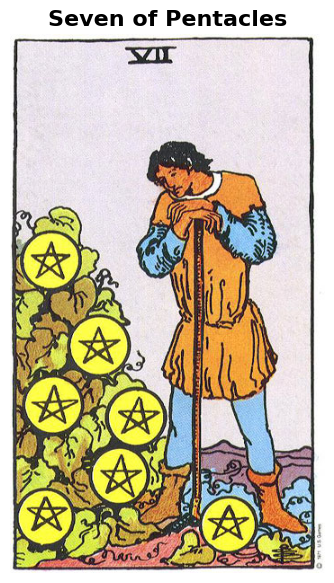

In [9]:
# Modeli yÃ¼kleme
model = SentenceTransformer('all-MiniLM-L6-v2')

# JSON dosyasÄ±ndan tarot kartlarÄ±nÄ± okuma
df_cards = pd.json_normalize(df['cards'])

# Kart aÃ§Ä±klamalarÄ±nÄ± hazÄ±rlama
card_descriptions = df_cards['meanings.light'].fillna('').tolist()
card_embeddings = model.encode(card_descriptions)

# KullanÄ±cÄ± girdisi
user_input = input("Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n: ") #KullanÄ±cÄ± Girdisinin Analiz Edilmesi.
user_embedding = model.encode(user_input)

# Benzerlik hesaplama
# kart aÃ§Ä±klamalarÄ± ile kullanÄ±cÄ±nÄ±n girdisinin benzerliÄŸi hesaplanÄ±yor ve en yÃ¼ksek
scores = util.cos_sim(user_embedding, card_embeddings)[0]
best_card_idx = scores.argmax().item()  # TamsayÄ±ya dÃ¶nÃ¼ÅŸtÃ¼rme

# En iyi eÅŸleÅŸmeyi yazdÄ±rma
best_card = df_cards.iloc[best_card_idx]

# Light ve Shadow anlamlarÄ±nÄ± kontrol etme
light_meanings = best_card['meanings.light']
shadow_meanings = best_card['meanings.shadow']
light_count = len(light_meanings)
shadow_count = len(shadow_meanings)

# Light ve Shadow'a gÃ¶re mesaj belirleme
if light_count > shadow_count:
    dominance_message = f"{ConsoleColors.GREEN}KartÄ±n genel yorumu: Olumlu ðŸŒŸ{ConsoleColors.RESET}"
elif shadow_count > light_count:
    dominance_message = f"{ConsoleColors.RED}KartÄ±n genel yorumu: Olumsuz âš¡{ConsoleColors.RESET}"
else:
    dominance_message = f"{ConsoleColors.BLUE}KartÄ±n genel yorumu: Dengeli âš–{ConsoleColors.RESET}"

# Kart bilgilerini yazdÄ±rma
print(f"\nSizin iÃ§in seÃ§ilen kart: {best_card['name']}")
print(f"AnlamÄ± (Light): {light_meanings}")
print(f"AnlamÄ± (Shadow): {shadow_meanings}")
print(dominance_message)

# Kart gÃ¶rselini gÃ¶sterme
image_path = os.path.join(data_dir, best_card['img'])
if os.path.exists(image_path):
    img = plt.imread(image_path)
    plt.figure(figsize=(5, 7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(best_card['name'], fontsize=16, fontweight='bold')
    plt.show()
else:
    print(f"GÃ¶rsel bulunamadÄ±: {image_path}")


 # soru Ã¶rnekleri   How will my career progress?    I'm feeling so stressed, what can I do?    What will my friendships be like?

In [10]:

# KullanÄ±cÄ± Girdisi ve Kart SeÃ§imi:
#Birinci Kod:
#KullanÄ±cÄ± tarafÄ±ndan girilen bir soru veya his, metin benzerlik hesaplamalarÄ± kullanÄ±larak kartlarla eÅŸleÅŸtirilir.
#KullanÄ±cÄ±nÄ±n girdisi, her bir kart aÃ§Ä±klamasÄ±yla karÅŸÄ±laÅŸtÄ±rÄ±lÄ±r ve en yÃ¼ksek benzerliÄŸe sahip kart seÃ§ilir.

#Ä°kinci Kod:
#KullanÄ±cÄ± girdisi, Ã¶nce bazÄ± anahtar kelimelerle kategorilere (suit) ayrÄ±lÄ±r (Ã¶rneÄŸin aÅŸk, iÅŸ, saÄŸlÄ±k vb.).
#Bu kategorilere dayalÄ± olarak kartlar filtrelenir ve en uygun kart rastgele seÃ§ilir.


#2. Kategorik SeÃ§im:
#Birinci Kod:
#Kartlar, kullanÄ±cÄ±nÄ±n sorusu ile doÄŸrudan metin benzerliÄŸi yoluyla seÃ§ilir. Kart aÃ§Ä±klamalarÄ±nÄ±n iÃ§erikleriyle hesaplama yapÄ±larak en iyi eÅŸleÅŸme bulunur.

#Ä°kinci Kod:
#Ã–ncelikle girdiye gÃ¶re bir kategori belirlenir (aÅŸk, kariyer, saÄŸlÄ±k vb.).
# KullanÄ±cÄ±nÄ±n sorusundaki anahtar kelimelere gÃ¶re "Pentacles", "Cups", "Wands" gibi suitlerden biri seÃ§ilir ve bu suit ile iliÅŸkili kartlar arasÄ±nda bir seÃ§im yapÄ±lÄ±r.


#Birinci Kod: Kart aÃ§Ä±klamalarÄ±na dayalÄ± metin benzerliÄŸi ile eÅŸleÅŸen kartÄ± bulur. Daha basit ve temel bir yapÄ± sunar.
#Ä°kinci Kod: Girdiyle iliÅŸkili bir suit seÃ§erek daha kategorik bir yaklaÅŸÄ±mla kartÂ Ã¶nerisiÂ yapar.

In [11]:
# Niyet Analizi

In [13]:

# NLP modeli yÃ¼kle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tarot kartlarÄ±nÄ± yÃ¼kle
data_dir = '/content/'  # GÃ¶rsellerin olduÄŸu klasÃ¶r yolu
json_path = '/content/tarot-images.json'
df = pd.read_json(json_path, orient='records')
df_cards = pd.json_normalize(df['cards'])

# Suit aÃ§Ä±klamalarÄ±
suit_explanations = {
    "Wands": "AteÅŸ elementinin serisidir. Aslan, KoÃ§, Yay burÃ§larÄ±nÄ± temsil eder. Bu kartlar hareketliliÄŸe, hÄ±za ve yaratÄ±cÄ±lÄ±ÄŸa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. YengeÃ§, Akrep, BalÄ±k burÃ§larÄ±nÄ± temsil eder. Bu kartlar duygulara, alÄ±ÅŸkanlÄ±klara ve bilinÃ§altÄ±na dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. Ä°kizler, Kova, Terazi burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼ÅŸÃ¼ncelere, inanÃ§lara ve zihinsel mÃ¼cadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. BoÄŸa, BaÅŸak, OÄŸlak burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼nya iÅŸleri, doÄŸa ve fiziksel yapÄ±ya dair bilgileri verir.",
    "Major Arcana": "BÃ¼yÃ¼k Arkana kartlarÄ± yaÅŸamÄ±n Ã¶nemli temalarÄ±nÄ± ve dÃ¶nÃ¼ÅŸÃ¼mlerini temsil eder. Her biri farklÄ± bir ders sunar."
}

# Kart gÃ¶rselini gÃ¶sterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}GÃ¶rsel bulunamadÄ±: {image_path}{ConsoleColors.RESET}")

# Light ve Shadow baskÄ±nlÄ±ÄŸÄ±na gÃ¶re mesaj ekleme
def determine_dominance(light_meanings, shadow_meanings):
    light_count = len(light_meanings)
    shadow_count = len(shadow_meanings)

    if light_count > shadow_count:
        return f"{ConsoleColors.GREEN}KartÄ±n genel yorumu: Olumlu ðŸŒŸ{ConsoleColors.RESET}"
    elif shadow_count > light_count:
        return f"{ConsoleColors.RED}KartÄ±n genel yorumu: Olumsuz âš¡{ConsoleColors.RESET}"
    else:
        return f"{ConsoleColors.BLUE}KartÄ±n genel yorumu: Dengeli âš–{ConsoleColors.RESET}"

# Niyet ve giriÅŸlere gÃ¶re kart Ã¶nerme
def recommend_card_by_intent(user_input):
    intent = "Genel"
    suit_selection = None

    if any(word in user_input for word in ["aÅŸk", "iliÅŸki", "sevgi", "arkadaÅŸ", "duygu", "romantizm"]):
        suit_selection = "Cups"
        intent = "AÅŸk ve Ä°liÅŸkiler"
    elif any(word in user_input for word in ["iÅŸ", "kariyer", "para", "zenginlik", "baÅŸarÄ±", "maddi"]):
        suit_selection = "Pentacles"
        intent = "Kariyer ve Maddiyat"
    elif any(word in user_input for word in ["saÄŸlÄ±k", "ÅŸifa", "hastalÄ±k", "iyileÅŸme", "beden", "ruh"]):
        suit_selection = "Major Arcana"
        intent = "SaÄŸlÄ±k ve Åžifa"
    elif any(word in user_input for word in ["dÃ¼ÅŸÃ¼nce", "zihin", "mantÄ±k", "karar", "analiz", "fikri"]):
        suit_selection = "Swords"
        intent = "Zihin ve Karar"
    elif any(word in user_input for word in ["yaratÄ±cÄ±", "enerji", "hareket", "tutku", "hedef"]):
        suit_selection = "Wands"
        intent = "YaratÄ±cÄ±lÄ±k ve Hareket"

    # SeÃ§ilen suit'e gÃ¶re kart filtreleme
    filtered_cards = df_cards[df_cards['suit'].str.contains(suit_selection, case=False, na=False)] if suit_selection else df_cards
    selected_card = filtered_cards.sample(1).iloc[0]

    # Kart bilgilerini yazdÄ±rma
    print(f"{ConsoleColors.ORANGE}{intent} kategorisinde sizin iÃ§in bir kart seÃ§tim!{ConsoleColors.RESET}")
    print(f"{ConsoleColors.BOLD}Kart Ä°smi:{ConsoleColors.RESET} {selected_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {selected_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {selected_card['meanings.shadow']}")

    # Suit aÃ§Ä±klamasÄ± ekleme
    suit_description = suit_explanations.get(suit_selection, "Genel bir kategori aÃ§Ä±klamasÄ± mevcut deÄŸil.")
    print(f"{ConsoleColors.BOLD}Suit AÃ§Ä±klamasÄ±:{ConsoleColors.RESET} {suit_description}")

    # Light ve Shadow anlamlarÄ±nÄ± deÄŸerlendir
    dominance_message = determine_dominance(selected_card['meanings.light'], selected_card['meanings.shadow'])
    print(dominance_message)

    display_card_image(selected_card)

    return selected_card


# Ä°kinci kart Ã¶nerme
def recommend_related_card(first_card):
    print(f"\n{ConsoleColors.YELLOW}Ä°lk kartÄ±nÄ±za gÃ¶re ikinci kart Ã¶neriliyor...{ConsoleColors.RESET}")

    # Ä°lk kartÄ±n light anlamÄ±nÄ± al
    first_card_meaning = first_card['meanings.light']

    # DiÄŸer kartlarÄ± filtrele (ilk kart hariÃ§)
    other_cards = df_cards[df_cards['name'] != first_card['name']]

    # TÃ¼m kartlarÄ±n light anlamlarÄ±nÄ± al ve benzerlik skoru hesapla
    card_meanings = other_cards['meanings.light'].tolist()
    embeddings = model.encode([first_card_meaning] + card_meanings)
    similarity_scores = util.cos_sim([embeddings[0]], embeddings[1:])

    # En yÃ¼ksek benzerlik skoruna sahip olan kartÄ± seÃ§
    best_match_index = similarity_scores.numpy().argmax()  # NumPy yÃ¶ntemi ile argmax iÅŸlemi
    second_card = other_cards.iloc[best_match_index]

    # Ä°kinci kart bilgilerini yazdÄ±r
    print(f"{ConsoleColors.BOLD}Ä°kinci Kart:{ConsoleColors.RESET} {second_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {second_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {second_card['meanings.shadow']}")

    # Suit aÃ§Ä±klamasÄ± ekle
    suit_description = suit_explanations.get(second_card['suit'], "Genel bir kategori aÃ§Ä±klamasÄ± mevcut deÄŸil.")
    print(f"{ConsoleColors.BOLD}Suit AÃ§Ä±klamasÄ±:{ConsoleColors.RESET} {suit_description}")

    # GÃ¶rseli gÃ¶ster
    display_card_image(second_card)

# Tarot kart Ã¶nerme uygulamasÄ±

def main():
    output = widgets.Output()
    display(output)

    while True:
        with output:
            clear_output(wait=True)
            user_input = input("\nBir soru sorun ya da ne hissettiÄŸinizi yazÄ±n (Ã‡Ä±kmak iÃ§in 'Ã§Ä±kÄ±ÅŸ'): ").strip()

            if user_input.lower() in ["Ã§Ä±kÄ±ÅŸ", "exit", "quit"]:
                print(f"{ConsoleColors.ORANGE}GÃ¶rÃ¼ÅŸmek Ã¼zere, tekrar bekleriz! ðŸŒŸ{ConsoleColors.RESET}")
                break

            # Ä°lk kartÄ± seÃ§
            first_card = recommend_card_by_intent(user_input)

            while True:
                cont = input(f"\nÄ°lk karta gÃ¶re ikinci bir kart seÃ§mek ister misiniz? (evet/hayÄ±r): ").strip().lower()
                if cont in ["evet", "yes"]:
                    recommend_related_card(first_card)
                    break  # Ä°kinci kart seÃ§ildi, dÃ¶ngÃ¼den Ã§Ä±k
                elif cont in ["hayÄ±r", "no"]:
                    print(f"{ConsoleColors.ORANGE}Harika bir gÃ¼n geÃ§irmenizi dilerim! ðŸŒŸ{ConsoleColors.RESET}")
                    break  # DÃ¶ngÃ¼den Ã§Ä±k
                else:
                    print(f"{ConsoleColors.RED}LÃ¼tfen 'evet' veya 'hayÄ±r' yazÄ±n.{ConsoleColors.RESET}")

            # KullanÄ±cÄ± "evet" veya "hayÄ±r" dedikten sonra dÄ±ÅŸ dÃ¶ngÃ¼ye dÃ¶n
            if cont in ["hayÄ±r", "no"]:
                break  # KullanÄ±cÄ± istemiyorsa tamamen Ã§Ä±k

# ProgramÄ± baÅŸlat
if __name__ == "__main__":
    main()

Output()


Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n (Ã‡Ä±kmak iÃ§in 'Ã§Ä±kÄ±ÅŸ'): kariyerim nasÄ±l ilerleyecek

Ä°lk karta gÃ¶re ikinci bir kart seÃ§mek ister misiniz? (evet/hayÄ±r): evet

Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n (Ã‡Ä±kmak iÃ§in 'Ã§Ä±kÄ±ÅŸ'): Ã§Ä±kÄ±ÅŸ


In [14]:
# EVET-HAYIR sorusu sorma

Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n (Ã‡Ä±kmak iÃ§in 'Ã§Ä±kÄ±ÅŸ'): 
>>> iyi bir iÅŸim olacak mÄ±

Sizin iÃ§in bir kart Ã§ektim!
Kart Ä°smi: Queen of Wands
Light Anlam: ['Paying close attention', 'Helping others focus on the issue at hand', 'Getting everyone to work together', 'Identifying common ground', 'Bringing people together, despite their differences', 'Using reverse psychology']
Shadow Anlam: ['Being distracted, or using your charms or skills to distract others from the goal', 'Calling attention to yourself with negative or unhealthy behaviors', 'Disrupting group activities as a means of feeding your own ego']
Ã‡ekiliÅŸ Tarihi: 2025-07-28 20:11:45

Suit AÃ§Ä±klamasÄ±: AteÅŸ elementinin serisidir. Aslan, KoÃ§, Yay burÃ§larÄ±nÄ± temsil eder. Bu kartlar hareketliliÄŸe, hÄ±za ve yaratÄ±cÄ±lÄ±ÄŸa dair bilgileri bize sunar.


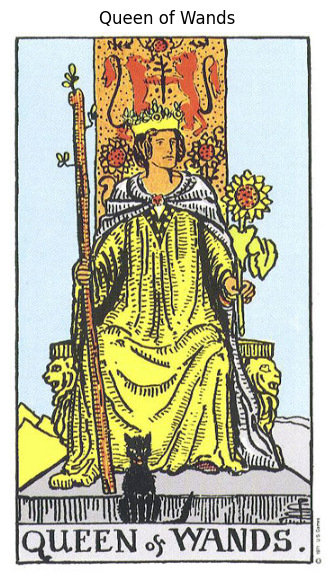


Cevap: HayÄ±r
Light Skor: 0.06
Shadow Skor: 0.08

Harika bir gÃ¼n geÃ§irmenizi dilerim! ðŸŒŸ


In [16]:

# NLP modeli yÃ¼kle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Suit aÃ§Ä±klamalarÄ±
suit_explanations = {
    "Wands": "AteÅŸ elementinin serisidir. Aslan, KoÃ§, Yay burÃ§larÄ±nÄ± temsil eder. Bu kartlar hareketliliÄŸe, hÄ±za ve yaratÄ±cÄ±lÄ±ÄŸa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. YengeÃ§, Akrep, BalÄ±k burÃ§larÄ±nÄ± temsil eder. Bu kartlar duygulara, alÄ±ÅŸkanlÄ±klara ve bilinÃ§altÄ±na dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. Ä°kizler, Kova, Terazi burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼ÅŸÃ¼ncelere, inanÃ§lara ve zihinsel mÃ¼cadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. BoÄŸa, BaÅŸak, OÄŸlak burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼nya iÅŸleri, doÄŸa ve fiziksel yapÄ±ya dair bilgileri verir.",
    "Major Arcana": "BÃ¼yÃ¼k Arkana kartlarÄ± yaÅŸamÄ±n Ã¶nemli temalarÄ±nÄ± ve dÃ¶nÃ¼ÅŸÃ¼mlerini temsil eder. Her biri farklÄ± bir ders sunar."
}

# Kart gÃ¶rselini gÃ¶sterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}GÃ¶rsel bulunamadÄ±: {image_path}{ConsoleColors.RESET}")

# Cevap deÄŸerlendirme fonksiyonu
def evaluate_card(card, user_input):
    # KullanÄ±cÄ±nÄ±n sorusunu vektÃ¶rleÅŸtir
    user_embedding = model.encode(user_input)

    # KartÄ±n "light" ve "shadow" anlamlarÄ±
    light_meaning = card['meanings.light']
    shadow_meaning = card['meanings.shadow']

    # VektÃ¶rleÅŸtirme ve benzerlik hesaplama
    light_embedding = model.encode(light_meaning)
    shadow_embedding = model.encode(shadow_meaning)

    light_score = util.cos_sim(user_embedding, light_embedding).mean().item()
    shadow_score = util.cos_sim(user_embedding, shadow_embedding).mean().item()

    # Evet veya HayÄ±r cevabÄ±nÄ± belirleme
    response = "Evet" if light_score > shadow_score else "HayÄ±r"

    # SonuÃ§larÄ± dÃ¶ndÃ¼r
    return {
        "response": response,
        "light_score": light_score,
        "shadow_score": shadow_score,
    }

# Rastgele kart Ã§ekme ve analiz yapma
def answer_user_question(user_input):
    # Rastgele bir kart Ã§ek
    selected_card = df_cards.sample(1).iloc[0]

    # KartÄ± analiz et
    result = evaluate_card(selected_card, user_input)

    # Kart bilgilerini yazdÄ±r
    print(f"{ConsoleColors.ORANGE}\nSizin iÃ§in bir kart Ã§ektim!{ConsoleColors.RESET}")
    print(f"{ConsoleColors.BOLD}Kart Ä°smi:{ConsoleColors.RESET} {selected_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {selected_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {selected_card['meanings.shadow']}")
    print(f"{ConsoleColors.BLUE}Ã‡ekiliÅŸ Tarihi:{ConsoleColors.RESET} {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    # Suit aÃ§Ä±klamasÄ± ekle
    suit_description = suit_explanations.get(selected_card['suit'], "Genel bir kategori aÃ§Ä±klamasÄ± mevcut deÄŸil.")
    print(f"{ConsoleColors.BOLD}Suit AÃ§Ä±klamasÄ±:{ConsoleColors.RESET} {suit_description}")

    # KartÄ±n gÃ¶rselini gÃ¶ster
    display_card_image(selected_card)

    # "Evet" veya "HayÄ±r" cevabÄ± yazdÄ±r
    print(f"\n{ConsoleColors.BOLD}Cevap:{ConsoleColors.RESET} {result['response']}")
    print(f"{ConsoleColors.GREEN}Light Skor:{ConsoleColors.RESET} {result['light_score']:.2f}")
    print(f"{ConsoleColors.RED}Shadow Skor:{ConsoleColors.RESET} {result['shadow_score']:.2f}")

# Ana program
def main():
    print(f"{ConsoleColors.BOLD}Bir soru sorun ya da ne hissettiÄŸinizi yazÄ±n (Ã‡Ä±kmak iÃ§in 'Ã§Ä±kÄ±ÅŸ'): {ConsoleColors.RESET}")
    user_input = input(">>> ").strip()

    if user_input.lower() in ["Ã§Ä±kÄ±ÅŸ", "exit", "quit"]:
        print(f"\n{ConsoleColors.ORANGE}GÃ¶rÃ¼ÅŸmek Ã¼zere, tekrar bekleriz! ðŸŒŸ{ConsoleColors.RESET}")
        return

    # KullanÄ±cÄ±nÄ±n sorusunu cevapla
    answer_user_question(user_input)

    print(f"\n{ConsoleColors.ORANGE}Harika bir gÃ¼n geÃ§irmenizi dilerim! ðŸŒŸ{ConsoleColors.RESET}")

# ProgramÄ± baÅŸlat
if __name__ == "__main__":
    main()


In [17]:
# KullanÄ±cÄ±dan bir kart ID'si alma ve o kartin anlamini cikarma


Kart kodunu girin (Ã¶rneÄŸin 'p13.jpg'): 
>>> m11.jpg

Kart bilgileri getiriliyor...ðŸ”®

Kart Ä°smi: Justice
NumarasÄ±: 11
Arcana: Major Arcana
Sembol: Trump
Kehanet: ['A legal verdict will be rendered soon', 'Someone is making a decision', 'You need to get the facts']
Olumlu Anlam (Light): ['Making an objective decision', 'Weighing an issue carefully before taking action', 'Appropriately scaling your reaction to a situation', 'Getting all the facts', 'Considering evidence', 'Deliberating']
GÃ¶lge Anlam (Shadow): ['Delivering harsh criticism', 'Obsessing on rules and regulations', 'Playing by the book even when it is destructive or counterproductive to do so', 'Confusing snap decisions with timely action', 'Playing favorites']
Suit AÃ§Ä±klamasÄ±: Genel bir kategori aÃ§Ä±klamasÄ± mevcut deÄŸil.
KartÄ±n genel yorumu: Olumlu ðŸŒŸ


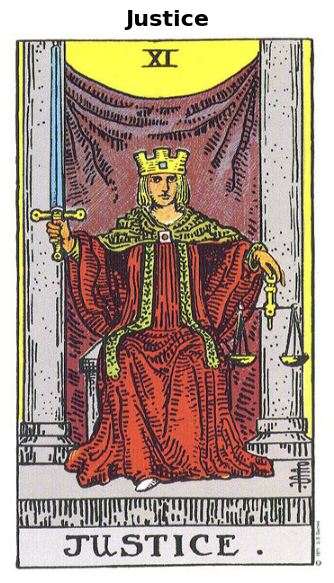


Harika bir gÃ¼n geÃ§irmenizi dilerim! ðŸŒŸ


In [18]:

# NLP modeli yÃ¼kle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tarot kartlarÄ±nÄ± yÃ¼kle
data_dir = '/content/'  # GÃ¶rsellerin olduÄŸu klasÃ¶r yolu
json_path = '/content/tarot-images.json'
df = pd.read_json(json_path, orient='records')
df_cards = pd.json_normalize(df['cards'])

# Suit aÃ§Ä±klamalarÄ±
suit_explanations = {
    "Wands": "AteÅŸ elementinin serisidir. Aslan, KoÃ§, Yay burÃ§larÄ±nÄ± temsil eder. Bu kartlar hareketliliÄŸe, hÄ±za ve yaratÄ±cÄ±lÄ±ÄŸa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. YengeÃ§, Akrep, BalÄ±k burÃ§larÄ±nÄ± temsil eder. Bu kartlar duygulara, alÄ±ÅŸkanlÄ±klara ve bilinÃ§altÄ±na dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. Ä°kizler, Kova, Terazi burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼ÅŸÃ¼ncelere, inanÃ§lara ve zihinsel mÃ¼cadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. BoÄŸa, BaÅŸak, OÄŸlak burÃ§larÄ±nÄ± temsil eder. Bu kartlar dÃ¼nya iÅŸleri, doÄŸa ve fiziksel yapÄ±ya dair bilgileri verir.",
    "Major Arcana": "BÃ¼yÃ¼k Arkana kartlarÄ± yaÅŸamÄ±n Ã¶nemli temalarÄ±nÄ± ve dÃ¶nÃ¼ÅŸÃ¼mlerini temsil eder. Her biri farklÄ± bir ders sunar."
}

# Kart gÃ¶rselini gÃ¶sterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}GÃ¶rsel bulunamadÄ±: {image_path}{ConsoleColors.RESET}")

# Kart bilgisini gÃ¶sterme ve suit aÃ§Ä±klamasÄ± ekleme
def show_card_by_name(card_name):
    print("\nKart bilgileri getiriliyor...\U0001F52E\n")

    # KartÄ± adÄ±ndan bul
    selected_card = df_cards[df_cards['img'].str.lower() == card_name.lower()]

    if not selected_card.empty:
        card_info = selected_card.iloc[0]

        # Kart bilgilerini yazdÄ±r
        print(f"Kart Ä°smi: {card_info['name']}")
        print(f"NumarasÄ±: {card_info['number']}")
        print(f"Arcana: {card_info['arcana']}")
        print(f"Sembol: {card_info['suit']}")
        print(f"Kehanet: {card_info['fortune_telling']}")
        print(f"Olumlu Anlam (Light): {card_info['meanings.light']}")
        print(f"GÃ¶lge Anlam (Shadow): {card_info['meanings.shadow']}")

        # Suit aÃ§Ä±klamasÄ± ekleme
        suit_description = suit_explanations.get(card_info['suit'], "Genel bir kategori aÃ§Ä±klamasÄ± mevcut deÄŸil.")
        print(f"{ConsoleColors.BOLD}Suit AÃ§Ä±klamasÄ±:{ConsoleColors.RESET} {suit_description}")

        # Light ve Shadow anlamlarÄ±nÄ± kontrol etme
        light_meanings = card_info['meanings.light']
        shadow_meanings = card_info['meanings.shadow']
        light_count = len(light_meanings)
        shadow_count = len(shadow_meanings)

        # Light ve Shadow'a gÃ¶re mesaj belirleme
        if light_count > shadow_count:
            dominance_message = f"{ConsoleColors.GREEN}KartÄ±n genel yorumu: Olumlu ðŸŒŸ{ConsoleColors.RESET}"
        elif shadow_count > light_count:
            dominance_message = f"{ConsoleColors.RED}KartÄ±n genel yorumu: Olumsuz âš¡{ConsoleColors.RESET}"
        else:
            dominance_message = f"{ConsoleColors.BLUE}KartÄ±n genel yorumu: Dengeli âš–{ConsoleColors.RESET}"

        print(dominance_message)

        # GÃ¶rseli yÃ¼kle ve gÃ¶ster
        image_path = os.path.join(data_dir, card_info['img'])
        if os.path.exists(image_path):
            img = plt.imread(image_path)

            # GÃ¶rseli Ã§iz
            fig, ax = plt.subplots(figsize=(5, 7))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(card_info['name'], fontsize=16, fontweight='bold')
            plt.show()
        else:
            print(f"{ConsoleColors.RED}GÃ¶rsel bulunamadÄ±: {image_path}{ConsoleColors.RESET}")
    else:
        print(f"{ConsoleColors.RED}'{card_name}' adÄ±nda bir kart bulunamadÄ±.{ConsoleColors.RESET}")

# Ana program
def main():
    print("\nKart kodunu girin (Ã¶rneÄŸin 'p13.jpg'): ")
    card_name = input(">>> ").strip()

    if card_name.lower() in ["Ã§Ä±kÄ±ÅŸ", "exit", "quit"]:
        print(f"\n{ConsoleColors.CYAN}GÃ¶rÃ¼ÅŸmek Ã¼zere, tekrar bekleriz! ðŸŒŸ{ConsoleColors.RESET}")
        return

    show_card_by_name(card_name)

    print(f"\n{ConsoleColors.ORANGE}Harika bir gÃ¼n geÃ§irmenizi dilerim! ðŸŒŸ{ConsoleColors.RESET}")

# ProgramÄ± baÅŸlat
if __name__ == "__main__":
    main()

In [19]:
# 3 KART ACILIMI

In [20]:
 # Bu fonksiyon, tarot kartlarÄ±nÄ± rastgele Ã§eker, seÃ§ilen kartlarÄ±n falÄ±nÄ± gÃ¶sterir.

def playDefault(mode): # kartlarÄ± Ã§ekme ve falÄ± okuma fonksiyonunun baÅŸlangÄ±cÄ±

  print('\nFalÄ±nÄ±zÄ± okuyorum... ðŸ”®\n')

  modes = [['GeÃ§miÅŸ','Åžimdi','Gelecek'], ['Durum','Aksiyon','SonuÃ§'], ['Sen','Partnerin','Ä°liÅŸki']] #tarot kartÄ± okumasÄ±nda kullanabileceÄŸimiz Ã¼Ã§ farklÄ± kart dizilimi

  cards3 = random.sample(range(78), k=3) # rastgele 3 kart seÃ§me

  #seÃ§ilen kartlarÄ±n falÄ±nÄ±, adlarÄ±nÄ± ve gÃ¶rsellerini depolamak iÃ§in boÅŸ listelerdir.
  fortunes = []
  names = []
  images = []

  # KartlarÄ±n OkunmasÄ± (for dÃ¶ngÃ¼sÃ¼)
  # KartlarÄ±n GÃ¶rselleÅŸtirilmesi
  for i in range(3):
    fortunes.append( df_cards.loc[cards3[i],'fortune_telling'][random.randint(0, len(df_cards.loc[cards3[i],'fortune_telling'])-1)] )
    names.append( df_cards.loc[cards3[i],'name'] )
    images.append( df_cards.loc[cards3[i],'img'] )

  fig, ax = plt.subplots(1, 3, figsize = (8,4))

  for i in range(3):
    img = plt.imread(data_dir + '/' + images[i])
    ax[i].imshow(img)
    ax[i].set_title(names[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#FalÄ±n GÃ¶sterilmesi
    print(f'Your \033[1m{modes[mode][i]}\033[0m is \033[1m{names[i]}.\033[0m {fortunes[i]}.')
  print()

In [21]:
def playLightDark(mode):

  print('\nFalÄ±nÄ±zÄ± okuyorum...  ðŸ”®\n')

# Modlar ve Light-Dark TanÄ±mlamasÄ±
  modes = [['GeÃ§miÅŸ','Åžimdi','Gelecek'], ['Durum','Aksiyon','SonuÃ§'], ['Sen','Partnerin','Ä°liÅŸki']]
  lightDark = ['meanings.light', 'meanings.shadow']

#KartlarÄ± ve Durumu SeÃ§me
  cards3 = random.sample(range(78), k=3)
  binary3 = [random.randint(0,1), random.randint(0,1), random.randint(0,1)]

#KartlarÄ±n Bilgilerini HazÄ±rlama
  fortunes = []
  names = []
  images = []

#KartÄ±n AnlamÄ±nÄ± SeÃ§me ve GÃ¶rselleri Ã‡ekme
  for i in range(3):
    orientation = lightDark[binary3[i]]
    fortunes.append( df_cards.loc[cards3[i], orientation][random.randint(0, len(df_cards.loc[cards3[i], orientation])-1)] )
    names.append( df_cards.loc[cards3[i], 'name'] )
    images.append( df_cards.loc[cards3[i], 'img'] )

#GÃ¶rsel OluÅŸturma (Matplotlib Kullanarak)
  fig, ax = plt.subplots(1, 3, figsize = (8,4))

#  KartÄ±n GÃ¶rselinin YÃ¶nlendirilmesi ve BaÅŸlÄ±klandÄ±rÄ±lmasÄ±
  for i in range(3):

    # Ã‡ekilen gÃ¶rsel ters ise Ã§evir
    img = plt.imread(data_dir + '/' + images[i])
    if binary3[i] == 1:
      img = scipy.ndimage.rotate(img, 180)
    else:
      img = scipy.ndimage.rotate(img, 0)

    ax[i].imshow(img)

    # Kasrt ters Ã§evrilmiÅŸse reversed yaz
    name = names[i]
    if binary3[i] == 1:
      name += ' (Reversed)'

    ax[i].set_title(names[i])

    ax[i].set_xticks([])
    ax[i].set_yticks([])

#Fal MesajÄ± YazdÄ±rma
    print(f'Your \033[1m{modes[mode][i]}\033[0m is \033[1m{name}.\033[0m {fortunes[i]}.')
  print()

In [22]:
# KullanÄ±cÄ± giriÅŸi

def validInt(min, max):
  while True:
    try:
      ans = int(input('Bir sayÄ± giriniz: '))

      if ans < min:
        raise Exception
      elif ans > max:
        raise Exception
      else:
        return ans

    except:
      return 0

NasÄ±l bÄ±r fal bakmak istersiniz? 
[1] 3- Klasik Fal 
[2] 3 Light & Shadow FalÄ± 
[*] Ã‡Ä±kÄ±ÅŸ
Bir sayÄ± giriniz: 1

[1] GeÃ§miÅŸ-Åžimdi-Gelecek 
[2] Durum-Aksiyon-SonuÃ§ 
[3] Sen-Partnerin-Ä°liÅŸki 
[*] Exit
Bir sayÄ± giriniz: 2

FalÄ±nÄ±zÄ± okuyorum... ðŸ”®

Your Durum is Four of Pentacles. A rainy day is comingâ€”it's time to save.
Your Aksiyon is The High Priestess. A mysterious woman arrives.
Your SonuÃ§ is Nine of Cups. Whatever you want, you'll get it.



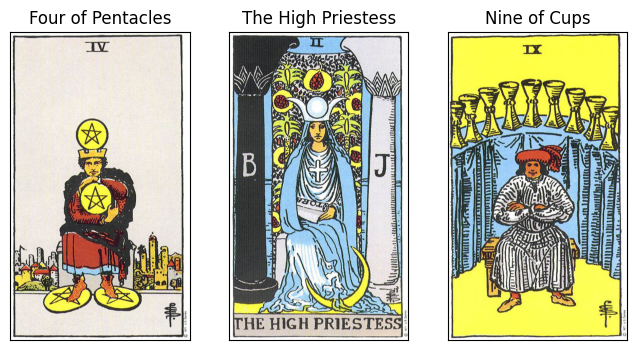

In [23]:
# KullanÄ±cÄ±dan Ana SeÃ§im YapmasÄ±nÄ± Ä°steme

print('NasÄ±l bÄ±r fal bakmak istersiniz? \n[1] 3- Klasik Fal \n[2] 3 Light & Shadow FalÄ± \n[*] Ã‡Ä±kÄ±ÅŸ')

r = validInt(1,2)
if r == 1:
  print('\n[1] GeÃ§miÅŸ-Åžimdi-Gelecek \n[2] Durum-Aksiyon-SonuÃ§ \n[3] Sen-Partnerin-Ä°liÅŸki \n[*] Exit')

  r = validInt(1,3)
  if r != 0:
    playDefault(r-1)
  else:
    print('\nFalÄ±nÄ±zÄ± okuyorum... ðŸ”®')

elif r == 2:
  print('\n[1] GeÃ§miÅŸ-Åžimdi-Gelecek \n[2] Durum-Aksiyon-SonuÃ§ \n[3] Sen-Partnerin-Ä°liÅŸki \n[*] Exit')

  r = validInt(1,3)
  if r != 0:
    playLightDark(r-1)
  else:
    print('\nCFalÄ±nÄ±zÄ± okuyorum... ðŸ”®')

else:
  print('\nFalÄ±nÄ±zÄ± okuyorum... ðŸ”®')


  r = validInt(1,3)
  if r != 0:
    playDefault(r-1)
  else:
    print('\nFalÄ±nÄ±zÄ± okuyorum... ðŸ”®')